In [1]:
import pandas as pd
import os
import dask.dataframe as dd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scanpy as sc
import numpy as np
import seaborn as sns
from sanbomics.plots import volcano

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
#pd.set_option("display.max_rows", None)
pd.options.mode.copy_on_write = True

In [2]:
# burada sadece verilerimi test ediyorum

df1 = pd.read_csv(r"C:\Users\Yusuf\Desktop\staj\marmara\datalar\tcga-luad-asıl\without_annotations\sample_600.tsv", sep="\t", skiprows=1)
df1

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
0,N_unmapped,NaN,NaN,1977052,1977052,1977052,NaN,NaN,NaN
1,N_multimapping,NaN,NaN,3985839,3985839,3985839,NaN,NaN,NaN
2,N_noFeature,NaN,NaN,2195761,19516923,19579647,NaN,NaN,NaN
3,N_ambiguous,NaN,NaN,3795041,969601,967190,NaN,NaN,NaN
4,ENSG00000000003.15,TSPAN6,protein_coding,769,382,387,15.1683,5.5968,5.5097
...,...,...,...,...,...,...,...,...,...
60659,ENSG00000288669.1,AC008763.4,protein_coding,0,0,0,0.0000,0.0000,0.0000
60660,ENSG00000288670.1,AL592295.6,lncRNA,201,102,106,9.9523,3.6722,3.6150
60661,ENSG00000288671.1,AC006486.3,protein_coding,0,0,0,0.0000,0.0000,0.0000
60662,ENSG00000288674.1,AL391628.1,protein_coding,5,0,5,0.0465,0.0172,0.0169


In [3]:
# buradaki kod tamamen yanlış bir iş yapıyor, bütün dosyalardaki her ekspresyon verisini alıp TOPLAYIP bana yazdırıyor

## Dosyaların bulunduğu dizin
#data_dir = r"C:\Users\Yusuf\Desktop\staj\marmara\datalar\tcga-luad-asıl\without_annotations"
#
## Tüm .tsv dosyalarını bul
#tsv_files = [f for f in os.listdir(data_dir) if f.endswith('.tsv')]
#
## İlk dosyayı okuyarak DataFrame oluştur (ilk satırı atla)
#first_file = os.path.join(data_dir, tsv_files[0])
#all_counts = pd.read_csv(first_file, sep='\t', index_col='gene_id', skiprows=1)
#
## Diğer dosyaları oku ve birleştir (ilk satırı atla)
#for file in tsv_files[1:]:
#    filepath = os.path.join(data_dir, file)
#    df = pd.read_csv(filepath, sep='\t', index_col='gene_id', skiprows=1)
#
#    # Ortak genleri bul ve birleştir
#    common_genes = all_counts.index.intersection(df.index)
#    all_counts = all_counts.loc[common_genes].join(df.loc[common_genes], lsuffix='_left', rsuffix='_right')
#
#    # Çakışan sütunları topla
#    for col in all_counts.columns:
#        if col.endswith('_left') and col[:-5] + '_right' in all_counts.columns:
#            all_counts[col[:-5]] = all_counts[col] + all_counts[col[:-5] + '_right']
#            all_counts = all_counts.drop(columns=[col, col[:-5] + '_right'])
#
## Sonuçları kaydet
#all_counts.to_csv("combined_count_matrix.csv")

In [4]:
# bu kod ile işim şu anda tamamen bitti, burada uzun ve karmaşık olan dosya adlarını sırasıyla luad ve lusc için basitleştirdim ve eski adları
# bir csv dosyasına kaydettim, onlar da ilgili data klasörlerinin içinde bekliyor, bu sayede kendim için işleri basitleştirirken herhangi bir
# veri kaybı yaşamadım

## Dosyaların bulunduğu dizin
#data_dir = r"C:\Users\Yusuf\Desktop\staj\marmara\datalar\tcga-luad-asıl\without_annotations"
#
## Dizin içindeki tüm dosyaları al
#dosyalar = os.listdir(data_dir)
#
## Yeni ve eski dosya adlarını tutacak listeler oluştur
#yeni_dosya_adlari = []
#eski_dosya_adlari = []
#
## Dosya adlarını değiştirme döngüsü
#for i, dosya in enumerate(dosyalar):
#    eski_yol = os.path.join(data_dir, dosya)
#    yeni_ad = f"sample_{i+1}.tsv"  # Yeni dosya adını oluştur
#    yeni_yol = os.path.join(data_dir, yeni_ad)
#
#    os.rename(eski_yol, yeni_yol)  # Dosya adını değiştir
#    yeni_dosya_adlari.append(yeni_ad)
#    eski_dosya_adlari.append(dosya)
#
## DataFrame oluştur
#df = pd.DataFrame({'Eski Dosya Adı': eski_dosya_adlari, 'Yeni Dosya Adı': yeni_dosya_adlari})
#
## DataFrame'i kaydet
#df.to_csv("dosya_adlari_degisiklikleri.csv", index=False)

In [5]:
# asıl kod bu ama ben tpm verilerini de inceleyebilmek için bir alttaki kopya kodu hazırlıyorum

## Dosya yolu ve dosyaları okuma
#data_dir = r"C:\Users\Yusuf\Desktop\staj\marmara\datalar\tcga-lusc-asıl\without_annotations"
#tsv_files = [f for f in os.listdir(data_dir) if f.endswith('.tsv')]
#
## Dask DataFrame'leri okuma ve sütun adlarını dosya adlarına göre güncelleme, burada tamamen stranded-first verilerini seçiyoruz
#ddf_list = []
#for file in tsv_files:
#    ddf = dd.read_csv(os.path.join(data_dir, file), sep='\t', skiprows=1, blocksize=None)
#    ddf = ddf.set_index('gene_id')
#    ddf = ddf[['stranded_first']].rename(columns={'stranded_first': file[:-4]})  # Dosya adını doğrudan sütun adı olarak kullan
#    ddf_list.append(ddf)
#
## Tüm Dask DataFrame'lerini birleştir
#merged_ddf = dd.concat(ddf_list, axis=1)
#
## Pandas DataFrame'e dönüştür
#all_counts = merged_ddf.compute()
#all_counts = all_counts.iloc[:-4] # son 4 satırı siler, bu son 4 satır ilk baştaki verilerin bir bilgisini içerdiğinden gereksiz
##all_counts.columns = [col[7:] for col in all_counts.columns]
#
## Sonuçları kaydet
##all_counts.to_csv("combined_stranded_lusc_matrix.csv")

In [6]:
# Dosya yolu ve dosyaları okuma
data_dir = r"C:\Users\Yusuf\Desktop\staj\marmara\datalar\tcga-luad-asıl\without_annotations"
tsv_files = [f for f in os.listdir(data_dir) if f.endswith('.tsv')]

# Dask DataFrame'leri okuma ve sütun adlarını dosya adlarına göre güncelleme, burada tamamen stranded-first verilerini seçiyoruz
ddf_list = []
for file in tsv_files:
    ddf = dd.read_csv(os.path.join(data_dir, file), sep='\t', skiprows=1, blocksize=None)
    ddf = ddf.set_index('gene_id')
    ddf = ddf[['tpm_unstranded']].rename(columns={'tpm_unstranded': file[:-4]})  # Dosya adını doğrudan sütun adı olarak kullan
    ddf_list.append(ddf)

# Tüm Dask DataFrame'lerini birleştir
merged_ddf = dd.concat(ddf_list, axis=1)

# Pandas DataFrame'e dönüştür
all_counts_tpm = merged_ddf.compute()
all_counts_tpm = all_counts_tpm.iloc[:-4] # son 4 satırı siler, bu son 4 satır ilk baştaki verilerin bir bilgisini içerdiğinden gereksiz
#all_counts.columns = [col[7:] for col in all_counts.columns]

# Sonuçları kaydet
#all_counts_tpm.to_csv("combined_tpm_luad_matrix.csv")

In [7]:
all_counts_lusc = pd.read_csv(r"C:\Users\Yusuf\Desktop\staj\marmara\combined_stranded_lusc_matrix.csv")
all_counts_luad = pd.read_csv(r"C:\Users\Yusuf\Desktop\staj\marmara\combined_stranded_luad_matrix.csv")
all_counts_tpm_lusc = pd.read_csv(r"C:\Users\Yusuf\Desktop\staj\marmara\combined_tpm_lusc_matrix.csv")
all_counts_tpm_luad = pd.read_csv(r"C:\Users\Yusuf\Desktop\staj\marmara\combined_tpm_luad_matrix.csv")

In [8]:
all_counts_tpm_lusc

,gene_id,sample_1,sample_10,sample_100,sample_101_control,sample_102,sample_103,sample_104,sample_105,sample_106_control,sample_107,sample_108,sample_109,sample_11,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_12,sample_120,sample_121_control,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_13,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_14,sample_140,sample_141,sample_142,...,sample_552,sample_553,sample_56_control,sample_57,sample_58_control,sample_59,sample_6,sample_60,sample_61,sample_62,sample_63,sample_64_control,sample_65,sample_66,sample_67,sample_68,sample_69,sample_7,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_8,sample_80,sample_81,sample_82_control,sample_83_control,sample_84,sample_85_control,sample_86_control,sample_87_control,sample_88,sample_89,sample_9,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99
0,ENSG00000000003.15,44.6566,43.6951,20.3830,39.2870,25.8074,62.4758,18.0641,12.1920,35.3779,28.1153,8.2211,22.5305,45.6996,55.6885,40.4474,56.1590,51.6463,45.5974,39.0813,24.9599,31.0800,46.5401,29.7248,52.2535,52.8773,23.2596,30.0430,42.1756,16.1532,59.3455,10.3153,75.2057,16.5755,35.7044,38.7126,51.4955,44.8843,40.9109,5.0215,73.9573,35.1751,34.7210,40.3108,50.9091,89.8609,69.6454,48.6917,33.1116,47.3416,...,65.1424,41.2426,26.0504,44.4547,58.0574,30.5611,31.6731,25.2926,10.2605,37.7477,27.2426,25.7596,56.7701,57.0216,57.2421,28.9493,45.5622,58.3005,73.1469,72.0095,36.0103,25.0440,60.2516,90.6571,15.7513,97.8507,35.6556,54.1031,39.0764,54.6729,38.4445,23.9708,30.2023,60.6540,38.6051,194.0740,33.4175,52.6602,51.8354,56.9336,30.3517,88.7679,30.4808,35.7583,44.6313,36.8280,25.2315,17.6325,9.6983,43.3630
1,ENSG00000000005.6,0.0000,0.0000,0.0953,0.0000,0.0000,0.0000,0.0000,0.0290,0.0544,0.9400,0.0281,0.1743,0.0461,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0467,0.0000,0.0246,0.0000,0.1181,0.0000,0.0000,0.0291,0.0000,0.0000,0.0000,0.0401,0.0000,0.0000,0.1442,0.0000,0.0000,0.2063,0.0000,0.0000,0.0000,0.0641,0.0000,0.0297,0.1760,0.0000,0.0391,0.0000,...,0.0000,0.0486,0.0000,0.0602,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0769,0.0388,0.0000,0.0000,0.0000,0.0000,0.0000,0.0296,0.0000,0.0825,0.0000,0.0000,0.1356,0.0410,0.0000,0.0000,0.0819,0.0429,0.0230,0.0566,0.0609,0.0000,0.0767,0.0375,0.0603,0.0000,0.0000,0.7846,0.1764,0.0770,0.0000,0.0000,0.0000,0.0845,0.0000,0.2571,0.0000,0.0359
2,ENSG00000000419.13,142.7488,166.2400,86.3289,138.0758,221.9496,140.6993,82.4250,54.4005,45.7380,53.7399,24.1178,65.5636,69.3967,122.0304,159.6469,275.9784,100.3673,96.1623,212.7149,168.7946,346.0674,190.6092,125.4140,113.8335,116.0697,65.1250,160.7124,106.7530,55.7262,113.2565,74.0008,223.4561,67.0459,104.4077,166.3793,122.7455,82.6477,191.8006,122.5115,119.5882,151.1085,93.3646,98.2265,84.3869,164.1138,102.4009,505.3598,110.0302,311.5272,...,125.7397,89.5514,127.8481,74.3733,68.5271,97.2772,103.9340,82.5729,106.3752,147.2071,61.9931,72.4473,113.4240,146.1812,101.6543,99.0980,92.6279,69.2430,151.0159,174.4961,38.3583,86.2993,221.6076,327.8462,130.9909,206.8264,53.5721,113.0581,120.3246,105.8568,81.2176,80.4904,74.8237,118.7790,135.2776,428.1805,62.9219,128.7704,131.5371,178.8606,101.7669,132.6473,111.4244,161.4543,292.9100,139.4354,99.0459,90.7836,38.6043,98.4266
3,ENSG00000000457.14,5.6215,4.1047,8.5806,4.5255,13.6317,9.6105,3.7582,5.7710,5.5339,4.6699,1.9487,4.4127,4.5215,6.6319,9.1994,16.1811,4.4786,6.7385,14.4879,11.3418,2.9939,5.6894,5.4665,9.1551,6.0839,7.0371,7.6815,7.3451,4.5462,9.3623,3.6376,5.5512,6.0676,6.7986,6.3684,9.3294,4.8079,4.3453,9.5207,27.8646,7.7168,4.9135,24.8553,6.2172,7.0165,6.8412,7.3601,7.0918,7.9517,...,6.1264,7.1229,9.1067,5.1536,6.2502,9.7003,6.3369,5.4922,3.5873,4.3296,5.9791,5.0611,8

In [9]:
all_counts_tpm_luad

,gene_id,sample_1,sample_10,sample_100,sample_101,sample_102,sample_103,sample_104_control,sample_105,sample_106_control,sample_107_control,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118_control,sample_119_control,sample_11_control,sample_12,sample_120,sample_121,sample_122,sample_123,sample_124_control,sample_125,sample_126,sample_127,sample_128,sample_129_control,sample_13,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139_control,sample_14,sample_140,sample_141_control,sample_142,...,sample_595,sample_596,sample_597,sample_598,sample_599_control,sample_6,sample_60,sample_600,sample_61,sample_62,sample_63,sample_64_control,sample_65,sample_66,sample_67,sample_68,sample_69,sample_7,sample_70,sample_71,sample_72_control,sample_73,sample_74,sample_75_control,sample_76,sample_77,sample_78,sample_79,sample_8,sample_80,sample_81,sample_82,sample_83,sample_84_control,sample_85,sample_86,sample_87,sample_88,sample_89,sample_9,sample_90,sample_91,sample_92_control,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99
0,ENSG00000000003.15,23.0141,62.7853,20.5880,30.7683,36.8457,52.0618,54.0583,28.8111,27.8041,31.0999,88.3225,87.5922,52.4081,16.4953,24.6353,21.9460,34.4362,15.1289,33.3739,17.5589,42.3420,85.8679,18.3930,46.2924,16.0750,56.5567,52.4828,69.7446,32.4032,47.7960,35.4834,77.3469,29.3240,70.4046,39.7682,34.0973,39.5374,82.2269,28.3773,34.7414,17.5732,68.7044,45.9016,54.9100,42.9271,66.7753,118.5588,70.0585,17.9310,...,48.0755,40.3607,28.5134,49.2765,78.3789,59.2028,19.6923,15.1683,16.5019,106.6166,96.0973,39.9013,43.6010,57.8054,53.0373,28.2433,105.4530,27.3398,15.9035,83.4113,15.3232,34.5834,18.8975,46.5733,33.0940,33.9334,15.1170,20.9176,46.5282,47.4562,38.4449,14.5914,32.4821,36.7481,58.8600,54.7095,36.2127,46.2845,29.9244,97.4557,56.5504,52.1102,41.6966,35.3733,33.3042,21.6142,16.6038,117.8762,29.6342,23.3552
1,ENSG00000000005.6,1.4128,0.0815,0.0725,0.0000,9.6271,0.1102,0.5243,0.0000,0.1150,0.5627,0.0612,0.4752,0.0315,8.1936,0.0844,0.0000,0.0268,0.2268,0.0000,0.0926,0.0358,0.0000,0.0687,0.1239,0.1273,0.9721,0.1297,0.0000,0.0000,0.0793,0.0426,0.0336,0.1194,11.1169,0.2321,0.0000,0.0942,0.0590,0.0000,0.0000,0.0000,0.0443,0.0000,0.0000,0.2434,0.0000,0.1991,0.0000,0.0000,...,0.0795,0.4187,0.0000,0.0000,0.0781,0.7917,0.0000,0.4243,1.7162,0.0744,1.4520,0.0000,0.2855,0.0000,0.0540,0.0693,0.0890,0.0349,0.0000,0.0000,0.0859,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0516,0.0000,0.3509,0.0523,0.0000,0.0625,0.0000,0.0000,0.0000,0.0265,13.7692,0.0000,0.0351,3.9432,0.0480,0.0000,0.1034,0.0000,0.1938,0.0000,0.0000,0.0385,0.0000
2,ENSG00000000419.13,50.6408,72.7386,61.2320,65.1635,47.2775,72.1569,102.6998,85.8150,86.2077,69.6930,79.2573,93.6497,60.5358,86.0564,75.8609,61.7008,99.6047,51.4320,46.9780,162.5360,78.6861,107.8177,77.5210,72.0583,77.2263,81.8622,90.4884,118.7168,57.3666,65.4313,73.7356,77.9762,95.3768,70.9371,89.8528,97.4170,65.9949,83.9421,78.1728,74.8463,206.1515,80.9030,102.9780,48.9378,72.0725,201.2410,89.7679,74.2081,73.1099,...,104.6428,82.5593,85.7661,110.4663,77.1974,112.0512,94.0823,53.7421,40.1894,65.7625,65.3033,72.6054,80.3129,116.3232,99.5711,70.0827,59.4124,61.2625,78.3369,96.8645,75.8701,43.3224,88.7727,86.2612,86.3875,50.7889,60.2306,122.3942,74.9477,86.1682,52.0788,66.9785,85.9154,54.1550,64.7106,94.0997,78.0344,43.5863,86.9097,98.3208,72.9181,147.0813,67.7315,86.9795,131.3756,95.2925,69.9088,139.0284,129.9132,151.6431
3,ENSG00000000457.14,16.6057,16.9140,4.4630,8.6634,5.1284,5.1630,4.2166,2.0658,5.7337,6.2227,16.3134,6.9120,4.3341,9.1464,5.8099,8.0095,7.3689,6.5009,5.4694,9.5669,5.9465,5.1991,3.3875,15.8915,4.1910,4.7898,11.7515,5.3163,7.6494,6.9524,5.1264,6.9053,4.6231,5.7823,9.0379,9.7336,7.5850,8.6421,6.4525,7.5485,3.3089,6.8277,9.2511,6.1472,7.5086,8.1025,6.7129,10.0079,5.5359,...,11.2367,8.0019,8.2665,8.3415,12.8504,9.8473,5.7935,6.9674,16.0273,8.5792,7.54

In [10]:
all_counts1 = all_counts_tpm_luad

In [11]:
all_counts1

,gene_id,sample_1,sample_10,sample_100,sample_101,sample_102,sample_103,sample_104_control,sample_105,sample_106_control,sample_107_control,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118_control,sample_119_control,sample_11_control,sample_12,sample_120,sample_121,sample_122,sample_123,sample_124_control,sample_125,sample_126,sample_127,sample_128,sample_129_control,sample_13,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139_control,sample_14,sample_140,sample_141_control,sample_142,...,sample_595,sample_596,sample_597,sample_598,sample_599_control,sample_6,sample_60,sample_600,sample_61,sample_62,sample_63,sample_64_control,sample_65,sample_66,sample_67,sample_68,sample_69,sample_7,sample_70,sample_71,sample_72_control,sample_73,sample_74,sample_75_control,sample_76,sample_77,sample_78,sample_79,sample_8,sample_80,sample_81,sample_82,sample_83,sample_84_control,sample_85,sample_86,sample_87,sample_88,sample_89,sample_9,sample_90,sample_91,sample_92_control,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99
0,ENSG00000000003.15,23.0141,62.7853,20.5880,30.7683,36.8457,52.0618,54.0583,28.8111,27.8041,31.0999,88.3225,87.5922,52.4081,16.4953,24.6353,21.9460,34.4362,15.1289,33.3739,17.5589,42.3420,85.8679,18.3930,46.2924,16.0750,56.5567,52.4828,69.7446,32.4032,47.7960,35.4834,77.3469,29.3240,70.4046,39.7682,34.0973,39.5374,82.2269,28.3773,34.7414,17.5732,68.7044,45.9016,54.9100,42.9271,66.7753,118.5588,70.0585,17.9310,...,48.0755,40.3607,28.5134,49.2765,78.3789,59.2028,19.6923,15.1683,16.5019,106.6166,96.0973,39.9013,43.6010,57.8054,53.0373,28.2433,105.4530,27.3398,15.9035,83.4113,15.3232,34.5834,18.8975,46.5733,33.0940,33.9334,15.1170,20.9176,46.5282,47.4562,38.4449,14.5914,32.4821,36.7481,58.8600,54.7095,36.2127,46.2845,29.9244,97.4557,56.5504,52.1102,41.6966,35.3733,33.3042,21.6142,16.6038,117.8762,29.6342,23.3552
1,ENSG00000000005.6,1.4128,0.0815,0.0725,0.0000,9.6271,0.1102,0.5243,0.0000,0.1150,0.5627,0.0612,0.4752,0.0315,8.1936,0.0844,0.0000,0.0268,0.2268,0.0000,0.0926,0.0358,0.0000,0.0687,0.1239,0.1273,0.9721,0.1297,0.0000,0.0000,0.0793,0.0426,0.0336,0.1194,11.1169,0.2321,0.0000,0.0942,0.0590,0.0000,0.0000,0.0000,0.0443,0.0000,0.0000,0.2434,0.0000,0.1991,0.0000,0.0000,...,0.0795,0.4187,0.0000,0.0000,0.0781,0.7917,0.0000,0.4243,1.7162,0.0744,1.4520,0.0000,0.2855,0.0000,0.0540,0.0693,0.0890,0.0349,0.0000,0.0000,0.0859,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0516,0.0000,0.3509,0.0523,0.0000,0.0625,0.0000,0.0000,0.0000,0.0265,13.7692,0.0000,0.0351,3.9432,0.0480,0.0000,0.1034,0.0000,0.1938,0.0000,0.0000,0.0385,0.0000
2,ENSG00000000419.13,50.6408,72.7386,61.2320,65.1635,47.2775,72.1569,102.6998,85.8150,86.2077,69.6930,79.2573,93.6497,60.5358,86.0564,75.8609,61.7008,99.6047,51.4320,46.9780,162.5360,78.6861,107.8177,77.5210,72.0583,77.2263,81.8622,90.4884,118.7168,57.3666,65.4313,73.7356,77.9762,95.3768,70.9371,89.8528,97.4170,65.9949,83.9421,78.1728,74.8463,206.1515,80.9030,102.9780,48.9378,72.0725,201.2410,89.7679,74.2081,73.1099,...,104.6428,82.5593,85.7661,110.4663,77.1974,112.0512,94.0823,53.7421,40.1894,65.7625,65.3033,72.6054,80.3129,116.3232,99.5711,70.0827,59.4124,61.2625,78.3369,96.8645,75.8701,43.3224,88.7727,86.2612,86.3875,50.7889,60.2306,122.3942,74.9477,86.1682,52.0788,66.9785,85.9154,54.1550,64.7106,94.0997,78.0344,43.5863,86.9097,98.3208,72.9181,147.0813,67.7315,86.9795,131.3756,95.2925,69.9088,139.0284,129.9132,151.6431
3,ENSG00000000457.14,16.6057,16.9140,4.4630,8.6634,5.1284,5.1630,4.2166,2.0658,5.7337,6.2227,16.3134,6.9120,4.3341,9.1464,5.8099,8.0095,7.3689,6.5009,5.4694,9.5669,5.9465,5.1991,3.3875,15.8915,4.1910,4.7898,11.7515,5.3163,7.6494,6.9524,5.1264,6.9053,4.6231,5.7823,9.0379,9.7336,7.5850,8.6421,6.4525,7.5485,3.3089,6.8277,9.2511,6.1472,7.5086,8.1025,6.7129,10.0079,5.5359,...,11.2367,8.0019,8.2665,8.3415,12.8504,9.8473,5.7935,6.9674,16.0273,8.5792,7.54

In [12]:
#all_counts1.columns = all_counts1.columns.astype(int)      #
all_counts1 = all_counts1.set_index(all_counts1["gene_id"], drop=True)
del all_counts1["gene_id"]
all_counts1 = all_counts1.sort_index(axis=1)                # bu üç kodda sample adlarımızı basitleştirdik(sadece reset_index yapsam daha mantıklıydı muhtemelen)
all_counts1.columns = all_counts1.columns.astype(str)       #
all_counts1 = all_counts1[all_counts1.sum(axis = 1) > 0]    # tamamen boş olan genlerden kurtulduk burda
#all_counts1 = all_counts1.T                                 # verimizi işleme hazır hâle getirmek için transpose'unu alıyoruz

In [13]:
all_counts1

,sample_1,sample_10,sample_100,sample_101,sample_102,sample_103,sample_104_control,sample_105,sample_106_control,sample_107_control,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118_control,sample_119_control,sample_11_control,sample_12,sample_120,sample_121,sample_122,sample_123,sample_124_control,sample_125,sample_126,sample_127,sample_128,sample_129_control,sample_13,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139_control,sample_14,sample_140,sample_141_control,sample_142,sample_143,...,sample_595,sample_596,sample_597,sample_598,sample_599_control,sample_6,sample_60,sample_600,sample_61,sample_62,sample_63,sample_64_control,sample_65,sample_66,sample_67,sample_68,sample_69,sample_7,sample_70,sample_71,sample_72_control,sample_73,sample_74,sample_75_control,sample_76,sample_77,sample_78,sample_79,sample_8,sample_80,sample_81,sample_82,sample_83,sample_84_control,sample_85,sample_86,sample_87,sample_88,sample_89,sample_9,sample_90,sample_91,sample_92_control,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99
gene_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,23.0141,62.7853,20.5880,30.7683,36.8457,52.0618,54.0583,28.8111,27.8041,31.0999,88.3225,87.5922,52.4081,16.4953,24.6353,21.9460,34.4362,15.1289,33.3739,17.5589,42.3420,85.8679,18.3930,46.2924,16.0750,56.5567,52.4828,69.7446,32.4032,47.7960,35.4834,77.3469,29.3240,70.4046,39.7682,34.0973,39.5374,82.2269,28.3773,34.7414,17.5732,68.7044,45.9016,54.9100,42.9271,66.7753,118.5588,70.0585,17.9310,33.3062,...,48.0755,40.3607,28.5134,49.2765,78.3789,59.2028,19.6923,15.1683,16.5019,106.6166,96.0973,39.9013,43.6010,57.8054,53.0373,28.2433,105.4530,27.3398,15.9035,83.4113,15.3232,34.5834,18.8975,46.5733,33.0940,33.9334,15.1170,20.9176,46.5282,47.4562,38.4449,14.5914,32.4821,36.7481,58.8600,54.7095,36.2127,46.2845,29.9244,97.4557,56.5504,52.1102,41.6966,35.3733,33.3042,21.6142,16.6038,117.8762,29.6342,23.3552
ENSG00000000005.6,1.4128,0.0815,0.0725,0.0000,9.6271,0.1102,0.5243,0.0000,0.1150,0.5627,0.0612,0.4752,0.0315,8.1936,0.0844,0.0000,0.0268,0.2268,0.0000,0.0926,0.0358,0.0000,0.0687,0.1239,0.1273,0.9721,0.1297,0.0000,0.0000,0.0793,0.0426,0.0336,0.1194,11.1169,0.2321,0.0000,0.0942,0.0590,0.0000,0.0000,0.0000,0.0443,0.0000,0.0000,0.2434,0.0000,0.1991,0.0000,0.0000,1.5346,...,0.0795,0.4187,0.0000,0.0000,0.0781,0.7917,0.0000,0.4243,1.7162,0.0744,1.4520,0.0000,0.2855,0.0000,0.0540,0.0693,0.0890,0.0349,0.0000,0.0000,0.0859,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0516,0.0000,0.3509,0.0523,0.0000,0.0625,0.0000,0.0000,0.0000,0.0265,13.7692,0.0000,0.0351,3.9432,0.0480,0.0000,0.1034,0.0000,0.1938,0.0000,0.0000,0.0385,0.0000
ENSG00000000419.13,50.6408,72.7386,61.2320,65.1635,47.2775,72.1569,102.6998,85.8150,86.2077,69.6930,79.2573,93.6497,60.5358,86.0564,75.8609,61.7008,99.6047,51.4320,46.9780,162.5360,78.6861,107.8177,77.5210,72.0583,77.2263,81.8622,90.4884,118.7168,57.3666,65.4313,73.7356,77.9762,95.3768,70.9371,89.8528,97.4170,65.9949,83.9421,78.1728,74.8463,206.1515,80.9030,102.9780,48.9378,72.0725,201.2410,89.7679,74.2081,73.1099,103.9621,...,104.6428,82.5593,85.7661,110.4663,77.1974,112.0512,94.0823,53.7421,40.1894,65.7625,65.3033,72.6054,80.3129,116.3232,99.5711,70.0827,59.4124,61.2625,78.3369,96.8645,75.8701,43.3224,88.7727,86.2612,86.3875,50.7889,60.2306,122.3942,74.9477,86.1682,52.0788,66.9785,85.9154,54.1550,64.7106,94.0997,78.0344,43.5863,86.9097,98.3208,72.9181,147.0813,67.7315,86.9795,131.3756,95.2925,69.9088,139.0284,129.9132,151.6431
ENSG00000000457.14,16.6057,16.9140,4.4630,8.6634,5.1284,5.1630,4.2166,2.0658,5.7337,6.2227,16.3134,6.9120,4.3341,9.1464,5.8099,8.0095,7.3689,6.5009,5.4694,9.5669,5.9465,5.1991,3.3875,15.8915,4.1910,4.7898,11.7515,5.3163,7.6494,6.9524,5.1264,6.9053,4.6231,5.7823,9.0379,9.7336,7.5850,8.6421,6.4525,7.5485,3.3089,6.8277,9.2

In [49]:
# bu kodun aynısını kullanarak metadata dosyamızı hazırlayacağız

# Örnek all_counts1 DataFrame'i (sütun isimleri)
columns = all_counts1.columns

# Yeni DataFrame oluşturma
metadataac1 = pd.DataFrame(columns, columns=["Sample"])
metadataac1.set_index("Sample", inplace=True)

# Condition sütununu oluşturma
metadataac1["Condition"] = metadataac1.index.map(lambda x: "C" if "control" in x else "RS")

metadataac1

,Condition
Sample,
sample_1,RS
sample_10,RS
sample_100,RS
sample_101,RS
sample_102,RS
...,...
sample_95,RS
sample_96,RS
sample_97,RS


In [50]:
all_counts1 = all_counts1.T
all_counts1

gene_id,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,ENSG00000001460.18,ENSG00000001461.17,ENSG00000001497.18,ENSG00000001561.7,ENSG00000001617.12,ENSG00000001626.16,ENSG00000001629.10,ENSG00000001630.17,ENSG00000001631.16,ENSG00000002016.18,ENSG00000002079.14,ENSG00000002330.14,ENSG00000002549.12,ENSG00000002586.20,ENSG00000002587.10,ENSG00000002726.21,ENSG00000002745.13,ENSG00000002746.15,ENSG00000002822.15,ENSG00000002834.18,ENSG00000002919.15,ENSG00000002933.9,ENSG00000003056.8,ENSG00000003096.14,ENSG00000003137.8,ENSG00000003147.19,ENSG00000003249.15,ENSG00000003393.15,ENSG00000003400.15,ENSG00000003402.20,ENSG00000003436.16,ENSG00000003509.16,ENSG00000003756.17,ENSG00000003987.14,ENSG00000003989.18,ENSG00000004059.11,ENSG00000004139.14,ENSG00000004142.12,ENSG00000004399.13,ENSG00000004455.17,...,ENSG00000288576.1,ENSG00000288577.1,ENSG00000288578.1,ENSG00000288579.1,ENSG00000288580.1,ENSG00000288581.1,ENSG00000288582.2,ENSG00000288583.1,ENSG00000288584.1,ENSG00000288585.1,ENSG00000288586.1,ENSG00000288588.1,ENSG00000288589.1,ENSG00000288593.1,ENSG00000288595.1,ENSG00000288596.2,ENSG00000288597.1,ENSG00000288598.1,ENSG00000288600.1,ENSG00000288601.1,ENSG00000288602.1,ENSG00000288603.1,ENSG00000288605.1,ENSG00000288607.1,ENSG00000288610.1,ENSG00000288611.1,ENSG00000288612.1,ENSG00000288615.1,ENSG00000288616.1,ENSG00000288617.1,ENSG00000288618.1,ENSG00000288622.1,ENSG00000288627.1,ENSG00000288631.1,ENSG00000288632.1,ENSG00000288637.1,ENSG00000288638.1,ENSG00000288648.1,ENSG00000288656.1,ENSG00000288657.1,ENSG00000288658.1,ENSG00000288659.1,ENSG00000288660.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
sample_1,23.0141,1.4128,50.6408,16.6057,8.2300,3.3141,65.4086,18.5654,34.0260,38.4381,3.2004,32.0131,9.2179,51.4686,4.4019,10.0544,51.2384,1.9204,10.7976,8.9432,1.2398,6.1806,48.5843,38.4972,4.4348,0.3787,0.3594,0.8978,2.5597,51.8097,9.3654,4.5354,21.8848,0.9332,5.4054,26.6099,7.0684,21.2884,23.6380,86.3920,296.2457,21.2036,59.2556,4.8910,104.6739,20.7095,5.8445,48.7629,45.0288,43.0317,...,0.4236,1.8868,0.0000,0.6516,0.5618,4.2915,0.0368,1.2678,0.0502,1.6853,4.5152,0.1200,3.786,2.8770,0.1388,27.9384,0.1464,2.0564,0.8881,1.1333,0.3949,8.4291,0.7783,0.0,0.5013,0.1239,3.1256,0.1241,0.0,0.0000,0.1088,0.0222,0.0,0.0,0.2193,0.4651,0.0000,0.0000,0.0000,0.0,0.4832,0.0,0.0000,10.8606,0.5260,59.8223,0.0,24.7384,0.0406,0.5430
sample_10,62.7853,0.0815,72.7386,16.9140,4.8953,26.3330,9.3064,33.9452,16.7325,42.1458,14.3004,63.5515,16.3901,34.1976,17.0458,18.5083,30.8523,2.7775,6.5038,18.4688,0.7532,35.6297,89.1920,59.7625,17.1222,2.0807,0.2948,0.1683,0.5406,157.2968,21.4317,19.3010,60.6706,0.3272,0.8394,38.2256,41.4280,10.6580,21.3376,27.8346,22.6850,11.2164,36.3869,1.0937,3.0124,187.0246,5.4583,142.9700,51.5200,80.1889,...,0.0000,0.5159,0.0000,0.0376,0.0432,0.2084,0.0000,0.1170,0.0000,0.3629,1.1299,0.0000,0.000,0.1327,0.0000,7.2977,0.0434,0.2755,0.9220,0.0000,0.0000,0.0000,0.0552,0.0,0.5397,0.0714,4.2828,0.0000,0.0,0.0000,0.0502,0.0000,0.0,0.0,0.0202,0.0511,3.3398,0.0000,0.0000,0.0,0.2027,0.0,0.3309,0.0000,1.5194,0.0000,0.0,11.3479,0.1375,1.7539
sample_100,20.5880,0.0725,61.2320,4.4630,1.4522,60.8278,43.5714,53.4222,6.4397,17.0058,4.5148,22.4241,9.6122,37.6256,47.2183,13.8072,17.6579,3.0633,2.5016,4.1002,0.0424,25.8812,108.0804,126.2464,2.6129,0.9047,0.0164,0.0999,0.2591,143.2932,23.6832,65.0762,82.8506,1.2492,2.3477,13.5464,13.9490,7.7881,19.3568,29.6166,66.3732,7.0213,14.4217,0.6412,19.6940,159.4954,2.2843,114.6106,141.1759,38.3877,...,0.0580,0.1435,0.0000,0.1003,0.0384,0.0000,0.0000,0.0000,0.0000,0.0461,0.8171,0.0493,0.000,0.3544,0.0000,1.6023,0.0301,0.1998,0.0912,0.0000,0.0000,0.0000,0.0000,0.0,0.2058,0.0254,0.6223,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0137,0.0,0.4509,0.0,0.0000,0.000

In [79]:
counts = all_counts1
countss = np.round(counts)
counts = pd.DataFrame(countss, columns=counts.columns).astype(int)
metadata1 = metadataac1

In [80]:
counts

gene_id,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,ENSG00000001460.18,ENSG00000001461.17,ENSG00000001497.18,ENSG00000001561.7,ENSG00000001617.12,ENSG00000001626.16,ENSG00000001629.10,ENSG00000001630.17,ENSG00000001631.16,ENSG00000002016.18,ENSG00000002079.14,ENSG00000002330.14,ENSG00000002549.12,ENSG00000002586.20,ENSG00000002587.10,ENSG00000002726.21,ENSG00000002745.13,ENSG00000002746.15,ENSG00000002822.15,ENSG00000002834.18,ENSG00000002919.15,ENSG00000002933.9,ENSG00000003056.8,ENSG00000003096.14,ENSG00000003137.8,ENSG00000003147.19,ENSG00000003249.15,ENSG00000003393.15,ENSG00000003400.15,ENSG00000003402.20,ENSG00000003436.16,ENSG00000003509.16,ENSG00000003756.17,ENSG00000003987.14,ENSG00000003989.18,ENSG00000004059.11,ENSG00000004139.14,ENSG00000004142.12,ENSG00000004399.13,ENSG00000004455.17,...,ENSG00000288576.1,ENSG00000288577.1,ENSG00000288578.1,ENSG00000288579.1,ENSG00000288580.1,ENSG00000288581.1,ENSG00000288582.2,ENSG00000288583.1,ENSG00000288584.1,ENSG00000288585.1,ENSG00000288586.1,ENSG00000288588.1,ENSG00000288589.1,ENSG00000288593.1,ENSG00000288595.1,ENSG00000288596.2,ENSG00000288597.1,ENSG00000288598.1,ENSG00000288600.1,ENSG00000288601.1,ENSG00000288602.1,ENSG00000288603.1,ENSG00000288605.1,ENSG00000288607.1,ENSG00000288610.1,ENSG00000288611.1,ENSG00000288612.1,ENSG00000288615.1,ENSG00000288616.1,ENSG00000288617.1,ENSG00000288618.1,ENSG00000288622.1,ENSG00000288627.1,ENSG00000288631.1,ENSG00000288632.1,ENSG00000288637.1,ENSG00000288638.1,ENSG00000288648.1,ENSG00000288656.1,ENSG00000288657.1,ENSG00000288658.1,ENSG00000288659.1,ENSG00000288660.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
sample_1,23,1,51,17,8,3,65,19,34,38,3,32,9,51,4,10,51,2,11,9,1,6,49,38,4,0,0,1,3,52,9,5,22,1,5,27,7,21,24,86,296,21,59,5,105,21,6,49,45,43,...,0,2,0,1,1,4,0,1,0,2,5,0,4,3,0,28,0,2,1,1,0,8,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,60,0,25,0,1
sample_10,63,0,73,17,5,26,9,34,17,42,14,64,16,34,17,19,31,3,7,18,1,36,89,60,17,2,0,0,1,157,21,19,61,0,1,38,41,11,21,28,23,11,36,1,3,187,5,143,52,80,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,7,0,0,1,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,0,0,11,0,2
sample_100,21,0,61,4,1,61,44,53,6,17,5,22,10,38,47,14,18,3,3,4,0,26,108,126,3,1,0,0,0,143,24,65,83,1,2,14,14,8,19,30,66,7,14,1,20,159,2,115,141,38,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0
sample_101,31,0,65,9,6,35,19,38,5,61,5,15,14,7,31,5,40,2,3,3,1,16,135,113,7,2,0,0,0,206,22,51,46,1,1,44,38,8,20,32,50,13,25,0,4,157,1,142,84,47,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,11,0,0
sample_102,37,10,47,5,2,17,39,54,21,23,5,15,14,27,18,0,24,2,3,6,1,26,46,242,5,82,0,1,0,183,25,103,47,0,5,42,29,8,19,27,20,12,23,0,2,151,3,211,77,65,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,9,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_95,22,0,95,7,2,115,33,46,7,34,5,24,9,51,67,13,28,4,3,7,0,15,159,140,6,1,0,0,0,114,25,47,85,2,16,18,4,12,31,55,87,10,28,2,52,110,2,88,123,39,...,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0
sample_96,17,0,70,7,7,23,45,95,5,51,2,10,14,41,18,2,18,2,3,4,0,18,162,80,13,1,0,0,0,108,13,28,62,3,1,37,19,8,26,25,14,9,11,0,14,121,1,105,34,65,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [81]:
dds = DeseqDataSet(counts=counts, metadata=metadata1, design_factors="Condition")

In [82]:
dds

AnnData object with n_obs × n_vars = 600 × 57772
    obs: 'Condition'
    obsm: 'design_matrix'

In [83]:
dds.deseq2()

Fitting size factors...
... done in 3.28 seconds.

Fitting dispersions...
... done in 45.51 seconds.

Fitting dispersion trend curve...
... done in 2.30 seconds.

Fitting MAP dispersions...
... done in 60.06 seconds.

Fitting LFCs...
... done in 24.97 seconds.

Calculating cook's distance...
... done in 4.45 seconds.

Replacing 4939 outlier genes.

Fitting dispersions...
... done in 5.42 seconds.

Fitting MAP dispersions...
... done in 5.45 seconds.

Fitting LFCs...
... done in 2.99 seconds.



In [84]:
dds

AnnData object with n_obs × n_vars = 600 × 57772
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'

In [85]:
stat_res = DeseqStats(dds, contrast = ('Condition','RS','C'))
stat_res.summary()

Running Wald tests...
... done in 6.39 seconds.



Log2 fold change & Wald test p-value: Condition RS vs C
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_id                                                                       
ENSG00000000003.15  47.921235        0.119136  0.090959  1.309777  0.190271   
ENSG00000000005.6    0.698731        0.486166  0.994418  0.488895  0.624916   
ENSG00000000419.13  89.848693        0.050173  0.061741  0.812630  0.416430   
ENSG00000000457.14   7.924025       -0.022259  0.066381 -0.335319  0.737384   
ENSG00000000460.17   4.458769        0.053990  0.100835  0.535429  0.592353   
...                       ...             ...       ...       ...       ...   
ENSG00000288667.1    1.154449        0.280195  0.831093  0.337140  0.736011   
ENSG00000288669.1    0.000000             NaN       NaN       NaN       NaN   
ENSG00000288670.1   10.146746       -0.040637  0.081314 -0.499759  0.617245   
ENSG00000288674.1    0.000000             NaN       NaN       NaN       NaN

In [86]:
res= stat_res.results_df
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSG00000000003.15,47.921235,0.119136,0.090959,1.309777,0.190271,0.440248
ENSG00000000005.6,0.698731,0.486166,0.994418,0.488895,0.624916,0.814941
ENSG00000000419.13,89.848693,0.050173,0.061741,0.812630,0.416430,0.665071
ENSG00000000457.14,7.924025,-0.022259,0.066381,-0.335319,0.737384,0.881652
ENSG00000000460.17,4.458769,0.053990,0.100835,0.535429,0.592353,0.794569
...,...,...,...,...,...,...
ENSG00000288667.1,1.154449,0.280195,0.831093,0.337140,0.736011,0.880961
ENSG00000288669.1,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000288670.1,10.146746,-0.040637,0.081314,-0.499759,0.617245,0.810410


In [87]:
res = res[res.baseMean >= 10]

In [88]:
# buna ek olarak mapping yapıp gen adlarını özgübleştirebilirim herhangi bir .tsv'den alıp, zamanım kalırsa bakacağım

res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSG00000000003.15,47.921235,0.119136,0.090959,1.309777,0.190271,0.440248
ENSG00000000419.13,89.848693,0.050173,0.061741,0.812630,0.416430,0.665071
ENSG00000000938.13,28.814351,0.038935,0.144151,0.270097,0.787086,0.904200
ENSG00000000971.16,47.432171,-0.021158,0.127865,-0.165470,0.868574,0.942284
ENSG00000001036.14,59.969772,0.072002,0.071542,1.006433,0.314207,0.575952
...,...,...,...,...,...,...
ENSG00000287627.1,11.804659,2.039870,0.618490,3.298148,0.000973,0.018511
ENSG00000287770.1,11.382454,0.972122,0.339368,2.864503,0.004177,0.045542
ENSG00000287906.1,19.873103,-0.017448,0.140267,-0.124389,0.901008,0.957103


In [89]:
#sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)]


In [90]:
#sigs

In [91]:
sc.tl.pca(dds)

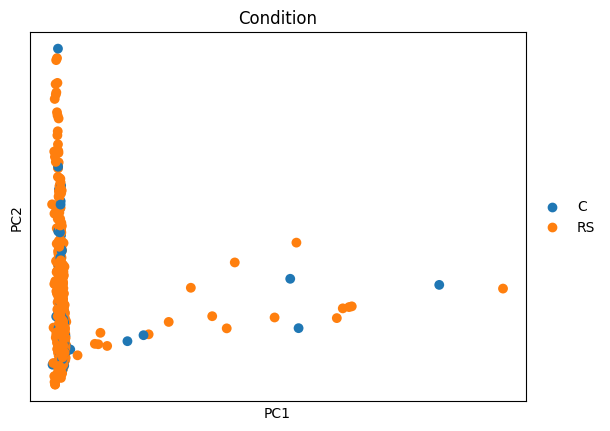

In [92]:
sc.pl.pca(dds, color = 'Condition', size = 200)